# Part 3: Optimization

In [43]:
import numpy as np 
import pandas as pd 
import numba 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
from scipy.stats import linregress
from itertools import product
import time
from tqdm import tqdm
import altair as alt
from IPython.display import Image
import seaborn as sns

# Introduction
Almost every tutorial on how to optimize a program starts with the quote: 
> *Premature optimization is the root of all evil*.  

As [this post](https://softwareengineering.stackexchange.com/a/80092) explains this means: 
> What this means is that, in the absence of measured performance issues you shouldn't optimize because you think you will get a performance gain. There are obvious optimizations, but anything that isn't a trivially clear optimization should be avoided until it can be measured.
The biggest problems with "premature optimization" are that it can introduce unexpected bugs and can be a huge time waster.

Before writing any code, therefore, it is a good idea to benchmark the existing code in order to find out which operations need to be sped up and which are already good enough (because for example they only take 1% of the total execution time).

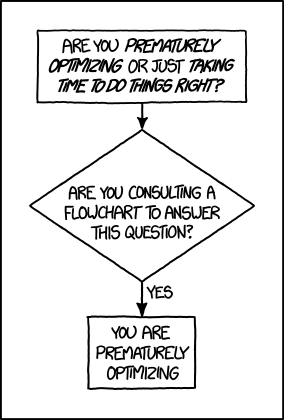

In [2]:
#The above quote is relevant to any project because apparently even seasoned programmers are tricked into prematurely optimizing:
Image("https://imgs.xkcd.com/comics/optimization.png")

# Profiling
Python and Jupyter offer many tools to benchmark code (e.g. by counting function calls, etc.). Since most of them are too advanced we adopt the simplest one: we use the `%%time` cell magic to time the execution of critical notebook cells. This has the disadvantage of yielding a result dependent on statistical fluctuations (`%%timeit` would be more robust but also time consuming) and on the machine used, but still provides useful and easy to read insight on our code - as long as we only consider "relative" informations.   
The result of such timing on a Google Colab machine yielded the following results:

In [3]:
#measured time = milliseconds
df_profiling = pd.read_csv("dati_per_visualizzare_il_profiling.csv",sep=";")
#CPU to wall time ratio
df_profiling["CWR"] = df_profiling["CPU_TIME"]/df_profiling["WALL_TIME"]
#number of cell
df_profiling["N_OF_CELL"] = df_profiling.index.values + 1
#total execution time in 'x m y s' format (minutes, seconds)
df_profiling["EXEC_TIME"]  = np.floor((df_profiling["WALL_TIME"]*1e-3)/60).astype("int").astype("str") + "m" + " " #minutes
df_profiling["EXEC_TIME"] += np.round(((df_profiling["WALL_TIME"]*1e-3)/60 - np.floor((df_profiling["WALL_TIME"]*1e-3)/60))*60, decimals=3).astype("str") + "s" #seconds

alt.Chart(df_profiling).mark_point(filled=True).encode(
    alt.X("N_OF_CELL"),
    alt.Y("WALL_TIME"),
    alt.Color("CWR"),
    alt.OpacityValue(0.7),
    tooltip = [alt.Tooltip("CELL"),alt.Tooltip("N_OF_CELL"),alt.Tooltip("CWR"),alt.Tooltip("EXEC_TIME")]
).configure_point(size=150)#.interactive()

alt.Chart(...)

The above graph tells us two important results:
- Every cell has a CPU to wall time ratio of $\approx 1$. Since the wall time is the total time it took to execute the cell (as if we had been staring at a clock on a wall) whereas CPU time is the time the CPU was actually busy this means that the main bottleneck of our code is the set of inefficient operations our CPU has to process. This is reasonable; the above graph was built using only `data_000000.txt` (i.e. few data points, less than 80 mb), so the machine didn't have to (for example) move a lot of data around in the RAM or to wait for the txt to download from the internet. This also helps us explain why the very first cell (`data_acquisition`) has a CWR of 0.23: the Colab VM had to download the csv from dropbox, which is slower than fitting it into RAM or processing with `pd.read_csv()`.
*Key idea*: we need to find alternative/more optimized version of our algorithms in order to reduce/make more efficient the computations we performed.
- Even though the actual numerical information on the Y axis doesn't have much meaning due to statistical/hw fluctuations we can clearly see that identifying events is the slowest part of our program, and this tells us that it's probably a good idea to heavily modify that cell. We can also see that applying the "close" filter is somewhat slow, too - so it's sensible to optimize that cell but not necessarily reworking it from the groud up. Similar things can be said about e.g. the computation of XL/XR and some other cells, although as said in the beginning except for obvious improvements for most cells here spending time optimizing would simply not make sense.
*Key idea*: we want to completely rewrite the algorithms used to group non-spurious hits and slightly overhaul the other cells. The point where to stop is of course arbitrary as optimization can be a never ending process; therefore we can stop when we feel satisfied with the result.

# Part 0: data acquisition and preprocessing

In [4]:
start = time.time()

In [5]:
#DATA ACQUISITION (exactly as in the original code)
dataset = pd.read_csv("data_000000.txt")

ntriggers = dataset[(dataset['TDC_CHANNEL'] == 137) | (dataset['TDC_CHANNEL'] == 138)].shape[0]
triggers = dataset[dataset['TDC_CHANNEL'] == 139].shape[0]
total_orbits = dataset['ORBIT_CNT'].nunique()

dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30

fpga = dataset['FPGA'] == 1 
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] < 129) 
trigger = dataset['TDC_CHANNEL'] == 139 

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel] 
for i in range(len(detectors)) : 
    dataset.loc[detectors[i],'DETECTOR'] = i+1 
dataset.loc[trigger,'DETECTOR'] = 0 

rest = dataset['TDC_CHANNEL'] % 4 
dic_replace = {0:1, 2:2, 3:3, 1:4}
dataset['LAYER'] = rest
dataset['LAYER'].replace(dic_replace, inplace=True)
dataset.loc[trigger,'LAYER'] = 0 
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

#we flag unused triggers for removal, i.e. we assign NaN to hits with TDC_CHANNEL equal to 129,130,...,138
for i in range(129,139) :
    dataset.loc[dataset["TDC_CHANNEL"] == i] = np.nan #.dropna() will remove these

#display(dataset.dropna())
dataset

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,116.0,1.897415e+09,1533.0,24.0,38345.000000,4.0,1.0
1,71.0,1.897415e+09,1650.0,21.0,41267.500000,4.0,3.0
2,67.0,1.897415e+09,980.0,8.0,24506.666667,4.0,3.0
3,70.0,1.897415e+09,1287.0,8.0,32181.666667,4.0,2.0
4,57.0,1.897415e+09,2162.0,22.0,54068.333333,1.0,4.0
...,...,...,...,...,...,...,...
1292121,139.0,1.920940e+09,2514.0,0.0,62850.000000,0.0,0.0
1292122,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0
1292123,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0
1292124,105.0,1.920940e+09,2510.0,17.0,62764.166667,4.0,4.0


## About data types
If we wanted to fully analyze our dataset (50+ gb) it obviously wouldn't fit in most computers' memory; even if we only took, say, 20%, we'd have 10+ gb of data - definitely manageable but still a lot. In order to avoid slow-downs due to memory saturation in any case using more efficient data types can reduce by a significant amount memory footprint. For example: every number in the original csv is an integer (no need to use floats) bigger than 0 (no need to use signed integers) and which can fit inside 8 or 32 bit. We can quickly compute which data type to use for each column of our dataset and measure the memory gain as follows:

In [6]:
dataset_slim = dataset.dropna() #no int nan exists, so the following line fails without dropna
dataset_slim = dataset_slim.astype({"TDC_CHANNEL":np.uint8,"ORBIT_CNT":np.uint32,"BX_COUNTER":np.uint16,"TDC_MEAS":np.uint8,"DETECTOR":np.uint8,"LAYER":np.uint8,"TIME":np.uint32})
print("dataset memory usage:")
dataset.info(memory_usage="deep")
print("\n"+"dataset_slim memory usage:")
dataset_slim.info(memory_usage="deep")

dataset memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292126 entries, 0 to 1292125
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   TDC_CHANNEL  1286751 non-null  float64
 1   ORBIT_CNT    1286751 non-null  float64
 2   BX_COUNTER   1286750 non-null  float64
 3   TDC_MEAS     1286750 non-null  float64
 4   TIME         1286750 non-null  float64
 5   DETECTOR     1286751 non-null  float64
 6   LAYER        1286751 non-null  float64
dtypes: float64(7)
memory usage: 69.0 MB

dataset_slim memory usage:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286750 entries, 0 to 1292124
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   TDC_CHANNEL  1286750 non-null  uint8 
 1   ORBIT_CNT    1286750 non-null  uint32
 2   BX_COUNTER   1286750 non-null  uint16
 3   TDC_MEAS     1286750 non-null  uint8 
 4   TIME         1286750 non-n

As we can see the default pandas type inference means we use data types much bigger than what we actually need (given the fact that for example DETECTOR is equal to 1,2,3 or 4); as a result the memory needed to fit our dataset drops from 69.0 to 27.1 mb. In what follows, though, we won't actually implement this type assignments for the following reasons:
- as we have seen from the interactive plot every nontrivial cell has $CWR\approx 1$, i.e. memory isn't an issue *with the size of this particular dataset*.
- actually using the above strategy would require nontrivial modifications of every cell. For example we observe that no integer NaN exists in python, therefore everytime we use a NaN to flag and remove spurious hits that assignment would fail. We could use another flag value; for example we may switch to using a negative number like -1 (but that would require signed integers) or the max value (but that would rule out a simple way to drop hits). Due to the fact that we don't need to implement this modifications and that we aren't trying to write the most general code possible we simply do nothing with regard to data types (according to the general guidelines given in the introduction).

## Using ORBIT_CNT as index + Removing orbits with no trigger activation
One of the purposes of this project is to identify with a common EVENT label hits belonging to the same event; therefore it's conceptually useful to use ORBIT_CNT (and later EVENT) to index hits. It also makes the code easier to understand and use (for example we only need 1 line to remove orbits with no trigger activations, see below); this is the first true new feature of this part of the project (along with the fact that we more aggressively drop useless columns to save memory).

In [7]:
df = dataset.dropna().astype({"LAYER":np.uint8,"DETECTOR":np.uint8}) #in the following cells we'll use LAYER to index df (and this fails if LAYER is not of int type). Furthermore since we know that neither DETECTOR nor LAYER will ever house a NaN this type assignment is safe & needs no further adjustments - something which isn't true for the other columns.

# df[df.TDC_CHANNEL == 139] yields all the rows with tdc_channel = 139, therefore by extracting their indices we can find out which indices i.e. orbits contain at least one trigger activation.

df = df.set_index("ORBIT_CNT")
df = df.loc[df[df.TDC_CHANNEL == 139].index.unique()] #this removes indices i.e. orbits without any trigger activation. We need to add .unique(); otherwise orbits with more than one trigger activation will appear at least twice in df because we'll be indexing df using the same orbit multiple times (once per unique trigger activation in each given orbit).
df = df.drop(["BX_COUNTER","TDC_MEAS"],axis=1) #no longer needed
df

,TDC_CHANNEL,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,
1.897415e+09,24.0,50360.833333,1,1
1.897415e+09,26.0,50366.666667,1,2
1.897415e+09,26.0,50660.833333,1,2
1.897415e+09,139.0,50700.000000,0,0
1.897415e+09,33.0,50661.666667,1,4
...,...,...,...,...
1.920940e+09,101.0,62761.666667,4,4
1.920940e+09,139.0,62850.000000,0,0
1.920940e+09,35.0,62813.333333,3,3


## Efficiently removing orbits with too few hits
In order to efficiently remove orbits with less than 4 hits we can use `df.groupby(["ORBIT_CNT"],group_keys=False).size() > 3` to (fancy) index our dataframe; this is true because this line yields a (smaller) dataframe where every row is indexed by a unique value of ORBIT_CNT and tells us how many hits have that value of the index i.e. orbit.

In [8]:
#remember: each acceptable orbit must have at least 3 physical hits (one line always passes through just 2 points) + 1 hit corresponding to the trigger activation
df = df[df.groupby(["ORBIT_CNT"],group_keys=False).size() > 3] # >3 == >= 4
df

,TDC_CHANNEL,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,
1.897415e+09,24.0,50360.833333,1,1
1.897415e+09,26.0,50366.666667,1,2
1.897415e+09,26.0,50660.833333,1,2
1.897415e+09,139.0,50700.000000,0,0
1.897415e+09,33.0,50661.666667,1,4
...,...,...,...,...
1.920940e+09,101.0,62761.666667,4,4
1.920940e+09,139.0,62850.000000,0,0
1.920940e+09,35.0,62813.333333,3,3


Since we'll actually need to use the previous filter again later we write a function to perform this cut. One way to do this is to simply use `.groupby("ORBIT_CNT").size()` as above; another is to use a pure numpy implementation (which we only report here for completeness' sake, since it doesn't seem to lead to substantial/consistent speed improvements).

In [9]:
#By applying np.unique to df.index we get an array containing unique values of ORBIT_CNT; np.unique can also be asked to return an array with the number of occurrences of each ORBIT_CNT value (i.e. the number of hits per each orbit) and the array that needs to be used with fancy indexing on the unique values array in order to rebuild the original array. By fancy indexing counts instead of unq with unqtags we can rebuild the original array but with the number of occurrences of each orbit in each slot - the number of hits happening in orbit x, that is. The result of this is identical to using groupby as already done

def remove_indexes_with_n_items_or_less(x,n=2) :
    unq,unqtags,counts = np.unique(x.index,return_inverse=True,return_counts=True)
    return x[counts[unqtags] > n]

def remove_indexes_with_n_items_or_less_groupby(x,n=2) : 
    return x[x.groupby(x.index,group_keys=False).size() > n]

## Efficient events identification and time pedestals computation
The following algorithm unifies 2-3 cells in the original program while also using a small fraction of the time needed; in fact we want to identify physical events, assign them the appropriate time pedestal, and finally drop events that last too long to be physical.   
The idea is the following: 
- Inside each orbit we first compute all possible time pedestals, which equal the times of trigger activations within that orbit;
- next for each time pedestal $t_0$ we make up the interval $[t_0-\Delta t, t_0+\Delta t]$ - where $\Delta t$ is an estimate of the longest time a physical event can last (i.e. $T_{\text{max}}+\delta t$, where $\delta t$ is the uncertainty);
- then (as explained in the next cell) with vectorization and broadcasting we assign each value of $t$ in a particular orbit to the closest time pedestal by checking which (if any) interval previously built it's in. Notice that this automatically guarantees that unphysical events that last too long can be easily removed; hits in such events won't be in any $[t_0-\Delta t, t_0+\Delta t]$, therefore their time pedestal will be a `NaN`.

### Grouping points into disjoint predetermined intervals using NumPy Broadcasting  
To explain the algorithm used it pays to look at things from a more general point of view; although this approach can be extended to an arbitrary number of dimensions we only develop it for points $\in\mathbb{R}$.  
Imagine we have $N$ points $x_1,x_2,\dots,x_N$ and $z$ disjoint intervals $[a_i,b_i], \ i=1,\dots,z$; our problem is to check which (if any) interval each $x_i$ is in. If the points are put in the (N,) array $X=[x_1,x_2,\dots,x_N]$ and the bounds are in a (z,2) array $B=[[a_1,b_1],\dots,[a_z,b_z]]$ we can consider for example the operation `X > B[:,np.newaxis,0]`. This corresponds to a logical comparison between a row vector (since `X.shape` is (N,)) and a column vector which contains each $a_j$ and has shape (z,1); due to how broadcasting works (see the following image) this operation involves vertically stacking $z$ copies of X and horizontally stacking $N$ copies of `B[:,np.newaxis,0]`.

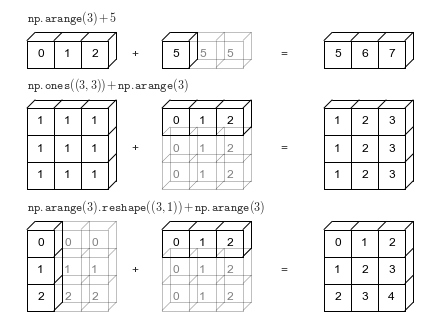

In [10]:
Image("https://okpanico.files.wordpress.com/2017/03/np145.png")
#ignore the first two examples, only the third is relevant to our algorithm

Since we're considering `X > B[:,np.newaxis,0]` due to the above the result of this will be a boolean array with z rows and N columns; each row corresponds to one of the $a_i$, whereas each column to one of the $x_j$. In particular: if element (i,j) of the resulting array is True this means that $x_j>a_i$ (rows = bounds, columns = points). If we then use `X &= X < B[:,np.newaxis,1]` and element (i,j) still comes out as True then it means that both $x_j>a_i$ and $x_j<b_i$ hold; therefore if we extract the position of nonzero (i.e. True) elements in the resulting array using `np.nonzero()` we'll find the indices (i,j) - which we can use as follows.  
`np.nonzero()` returns a tuple of 2 arrays; the first contains the row index of nonzero elements, the second the column index of nonzero items. Due to the above row i corresponds to interval i, whereas column j to point j; if we index an empty array with `nz[1]` and set the resulting elements equal to `nz[0]` we'll therefore have an (N,) array such that element j is equal to i. This means that we successfully built a copy of X where each point $x_j$ has been replaced with the index $i$ of the interval it's in; if the result is initialized as a `NaN` array then points that are in no interval will instead have `NaN`.   
The array we built this way, therefore, on one hand groups hits belonging to different events (e.g. if two hits in the same orbit belong to interval 1 and 2 respectively then this means the first hit is associated with event 1 and the second with event 2), and on the other helps us assign the time pedestals (i.e. if one hit has EVENT equal to 1 then by using `B[1]` we can find the corrisponding time window and therefore the appropriate value of $t_0$, which is the one used to build that interval).

In [11]:
#BOUNDS ARRAY COMPUTATION
#First we compute all possible time pedestal values by recalling that each hits has a time pedestal equal to the time of closest trigger activation
v = df.loc[df["TDC_CHANNEL"] == 139,"TIME"].groupby("ORBIT_CNT").apply(np.array) #no need to use .to_numpy() since we actually want a series (we need the indices)
print(v)

#Notice: due to .apply(np.array) each slot of v is an array with 1 or more elements; for example v.iloc[22] contains the times corresponding to 2 trigger activations.
#this cell might be made slow by .apply(), but it's fast enough that we don't need to worry - and any alternative implementation would probably be less readable.

ORBIT_CNT
1.897415e+09    [50700.0]
1.897415e+09    [70300.0]
1.897415e+09    [33375.0]
1.897416e+09    [30850.0]
1.897416e+09    [29950.0]
                  ...    
1.920940e+09    [84425.0]
1.920940e+09    [47725.0]
1.920940e+09      [350.0]
1.920940e+09    [13700.0]
1.920940e+09    [62850.0]
Name: TIME, Length: 90843, dtype: object


In [12]:
#function using numpy broadcasting to implement the above
def findCells1d(points, bounds) : #this easily generalizes to n dim., we only need to add extra conditions to allInBounds
    #points = points.reshape((-1,)) #not needed if we don't use multiprocessing, good idea otherwise

    # checks whether points are within bounds
    # dimension 0 = bound
    # dimension 1 = point
    allInBounds  = (points > bounds[:,None,0]) #broadcasting: row vector (with 1 element) > column vector
    allInBounds &= (points < bounds[:,None,1]) #this usage of None is equivalent to np.newaxis
    #by adding for example allInBounds &= (points < bounds[:,None,2]) and allInBounds &= (points < bounds[:,None,3]) we can work with points/rectangles in R2, etc. 

    # nz[0] = indices along dim 0 (bound)
    # nz[1] = indices along dim 1 (point)
    nz = np.nonzero(allInBounds)

    # result initialization
    r = np.full(points.shape[0], np.nan) #this way points in no intervals will have nan in the result
    # we use nz[1] to index the point position and nz[0] to tell which interval the point belongs to
    r[nz[1]] = nz[0]
    return r 

In [13]:
df["EVENT"] = np.nan #we initialize the new columns
df["TIME_PEDESTAL"] = np.nan

#we loop on ORBIT_CNT; for each orbit we extract the points (i.e. the times) to check with the intervals [t1,t2]=[t -+ delta t]

for index,subframe in tqdm(df.groupby("ORBIT_CNT")) : #having already eliminated orbits without trigger activations we can use v[index] with impunity (index will never refer to items outside v)
    t = v.loc[index] #this is an array with 1 or more elements
    t1, t2 = t - 415, t + 415
    T = np.vstack((t1,t2)).T #row 0 of np.vstack((t1,t2)) contains every a_i, row 1 every b_i; by transposing we can obtain the array where each row is one [a_i,b_i] i.e. the bounds array we need
    event = findCells1d(subframe.loc[subframe.DETECTOR != 0,"TIME"].to_numpy(),T) #if t is in interval 0 then its hit belongs to event 0. nan --> that hit is in no interval
    df.loc[index,"EVENT"].loc[subframe.DETECTOR != 0] = event+1 #to get a "human" number
    #once we know the value of EVENT we can use EVENT itself to index array t (cioè t) assigned above; this corresponds to setting the correct time pedestal, which in turn determined the correct interval
    try : #since there exists no int nan the following line fails if it operates on a nan (i.e. spurious hit); if this is the case we do nothing
        df.loc[index,"TIME_PEDESTAL"].loc[subframe.DETECTOR != 0] = t[event.astype(int)]
    except :
        continue #pass works as well
df

#assigning not only EVENT but also TIME_PEDESTAL in the same loop only slows it down by ~35 s, therefore it's worth it

100%|██████████| 90843/90843 [01:54<00:00, 792.98it/s]


,TDC_CHANNEL,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL
ORBIT_CNT,,,,,,
1.897415e+09,24.0,50360.833333,1,1,1.0,50700.0
1.897415e+09,26.0,50366.666667,1,2,1.0,50700.0
1.897415e+09,26.0,50660.833333,1,2,1.0,50700.0
1.897415e+09,139.0,50700.000000,0,0,NaN,NaN
1.897415e+09,33.0,50661.666667,1,4,1.0,50700.0
...,...,...,...,...,...,...
1.920940e+09,101.0,62761.666667,4,4,1.0,62850.0
1.920940e+09,139.0,62850.000000,0,0,NaN,NaN
1.920940e+09,35.0,62813.333333,3,3,1.0,62850.0


## Further optimizations: Parallelization/Multiprocessing with `multiprocessing`
The fact that, say, $x_1>a_3$ and that $x_2<b_1$ are independent of one another; therefore there's no need to execute one instruction before the other. By default python works sequentially using only one core; if we could parallelize these two instructions, therefore, we could both put to better use our hardware AND finish the computation sooner.   
To parallelize `findCells1d` we cannot use `@numba.jit(nopython=True,parallel=True)` since as of now numba doesn't support 2D+ broadcasting, so rather than abandoning that elegant approach we turn to the `multiprocessing` module. The following cell (disabled by default) wraps/parallelizes our function in a simple way, but unfortunately can't be used directly as well for a deeper reason than the numba approach.    
In order to parallelize the execution of, say, N operations the python kernel first needs to split N into various chuncks and then distributing them across memory; this adds an *overhead*, i.e. some extra time needed to execute the cell. If N is very large this overhead is negligible and the end result is a cell execution which would otherwise be very slow/unfeasible (another perk of parallelization i.e. splitting into chuncks is that they don't have to all fit into memory at the same time, and therefore there exist values of N that simply are too large to work without parallelization), but if N is small then this overhead might be so large that parallelization actually makes code execution *slower*.  
This means that if we parallelize orbit by orbit (i.e. we simply swap `findCells1d` with `findCells1dParallel` inside the for loop) the overhead will make everything much slower since each orbit contains relatively few hits; in order to make this work we would need to completely drop the for loop and just use a "universal" bounds array. This is very easy to implement but cannot actually work; the reason for this is that to create a universal bounds array we must use *absolute times*, not *times relative to one particular orbit* - but since TIME << ORBIT_CNT we have a loss of information in that the resulting points and bounds array will be wildly different from what they should be to faithfully represent our dataset. This might be adressed by trasforming the data in order to make these orders of magnitude more uniform (maybe using a log scale, subtracting the mean or using more advanced techniques/mappings), but since we don't need to do this (the previous cell already guarantees a more than satisfying speed improvement) we do nothing to improve it further.

In [14]:
if False :
    def findCells1dParallel(points, bounds, chunksize=100):
        import multiprocessing as mp
        from functools import partial

        func = partial(findCells, bounds=bounds)

        with mp.Pool() as p : #opening a processes pool introduces an overhead
            return np.hstack(p.map(func, points, chunksize))

## Using ORBIT_CNT + EVENT as indices
We now switch to using both ORBIT_CNT and EVENT as one multiindex for each hit; this makes sense physically since one of our purposes was to identify each physical hit with an orbit-event pair, and is also useful because dropping certain values of the index means dropping events as a whole instead of single hits.   
Before setting the new indices we can drop the NaN, which correspond to hits not belonging to any interval and to triggers (which are in no interval since we used > instead of >=, etc.); both don't correspond to physical hits and therefore are to be discarded.  
Also since we are discarding some more hits than before and we're grouping the surviving hits in smaller groups (orbit and event instead of just ORBIT_CNT) we need to re-apply the "at least 2 hits per event" filter.

In [15]:
#rows with nans = either triggers (no longer useful since we already have the time pedestals) and spurious hits

df = df.dropna().reset_index().astype({"EVENT":int}).set_index(["ORBIT_CNT","EVENT"]) #new multiindex. Notice that EVENT need not be a float
df = remove_indexes_with_n_items_or_less_groupby(df) #notice that this functions checks the index, whether that's just the orbit or orbit+event; therefore we don't have to modify it wrt to earlier usage. Also notice that since .dropna() just removed the triggers each event must now contain at least 3 hits instead of 4, i.e. we can use the default value n=2
#df = remove_indexes_with_n_items_or_less(df) #the 2 equivalent functions are as fast and work as well
df

TDC_CHANNEL          TIME  DETECTOR  LAYER  TIME_PEDESTAL
ORBIT_CNT    EVENT                                                           
1.897415e+09 1             24.0  50360.833333         1      1        50700.0
             1             26.0  50366.666667         1      2        50700.0
             1             26.0  50660.833333         1      2        50700.0
             1             33.0  50661.666667         1      4        50700.0
             1             27.0  50609.166667         1      3        50700.0
...                         ...           ...       ...    ...            ...
1.920940e+09 1            106.0  62695.000000         4      2        62850.0
             1            101.0  62761.666667         4      4        62850.0
             1             35.0  62813.333333         3      3        62850.0
             1             37.0  62829.166667         3      4        62850.0
             1            105.0  62764.166667         4      4        62850.0

[551844 rows x 5 columns]

## Dropping events distributed along multiple detectors
We use the same strategy seen in the previous program (i.e. we use `.mode()[0]` to find the most common detector), but with a vectorized (therefore faster) approach looping over events instead of using `.apply()` with a custom function.

In [16]:
#adesso devo risolvere il problema di eliminare gli eventi spalmati su più detector!

for index,subframe in tqdm(df.groupby(df.index)) :
    #most_common_detector = subframe.DETECTOR.mode()[0] #this line and the next one are more verbose but equivalent to the third
    #df.loc[index,"DETECTOR"].loc[subframe.DETECTOR != most_common_detector] = np.nan

    df.loc[index,"DETECTOR"].loc[subframe.DETECTOR != subframe.DETECTOR.mode()[0]] = np.nan

df = df.dropna()
df = remove_indexes_with_n_items_or_less_groupby(df) #once again the default value n=2 is appropriate since we need not account for triggers separately

#we no longer need the DETECTOR column so we drop it
df = df.drop("DETECTOR",axis=1)
df

100%|██████████| 80045/80045 [01:32<00:00, 867.73it/s]


TDC_CHANNEL          TIME  LAYER  TIME_PEDESTAL
ORBIT_CNT    EVENT                                                 
1.897415e+09 1             24.0  50360.833333      1        50700.0
             1             26.0  50366.666667      2        50700.0
             1             26.0  50660.833333      2        50700.0
             1             33.0  50661.666667      4        50700.0
             1             27.0  50609.166667      3        50700.0
...                         ...           ...    ...            ...
1.920940e+09 1            106.0  62695.000000      2        62850.0
             1            101.0  62761.666667      4        62850.0
             1             35.0  62813.333333      3        62850.0
             1             37.0  62829.166667      4        62850.0
             1            105.0  62764.166667      4        62850.0

[551844 rows x 4 columns]

## Dropping events with less than 3 layers active
We can perform an operation very similar to `remove_indexes_with_n_items_or_less_groupby`; this time instead of grouping by index and using `.size()` to check whether we have at least `n+1=3` elements in the index column we use `.nunique()` to check that we have at least 3 *unique* elements in the LAYER column.

In [17]:
#this is distinct from asking that at least 3 hits be in each event
df = df[df.groupby(df.index).nunique()["LAYER"] > 2] #we drop indices (i.e. ORBIT_CNT + EVENT = absolute events) that have less than 3 unique elements in the LAYER column
df

TDC_CHANNEL          TIME  LAYER  TIME_PEDESTAL
ORBIT_CNT    EVENT                                                 
1.897415e+09 1             24.0  50360.833333      1        50700.0
             1             26.0  50366.666667      2        50700.0
             1             26.0  50660.833333      2        50700.0
             1             33.0  50661.666667      4        50700.0
             1             27.0  50609.166667      3        50700.0
...                         ...           ...    ...            ...
1.920940e+09 1            106.0  62695.000000      2        62850.0
             1            101.0  62761.666667      4        62850.0
             1             35.0  62813.333333      3        62850.0
             1             37.0  62829.166667      4        62850.0
             1            105.0  62764.166667      4        62850.0

[550938 rows x 4 columns]

## Dropping events with multiple cells active on the same layer
`df.groupby(df.index).size()` tells us how many hits are associated to the same value of EVENT (i.e. to the same physical event), whereas `df.groupby(df.index).nunique()["LAYER"]` how many unique values of LAYER can be found in each event. If these 2 values differ for a certain event then it means that there are more hits than there are unique active layers, i.e. at least 2 unique hits share the same unique layer; when this happens we discard the event.  
Notice that this is the same idea used in the original code, where `set` was used to count unique values of LAYER; the difference is that we don't use a custom function + `.apply()`, resulting in a vectorized approach with is faster and easier to understand and read.

In [18]:
df = df[df.groupby(df.index).size() == df.groupby(df.index).nunique()["LAYER"]]
df

TDC_CHANNEL          TIME  LAYER  TIME_PEDESTAL
ORBIT_CNT    EVENT                                                 
1.897415e+09 1             86.0  70072.500000      2        70300.0
             1             87.0  69957.500000      3        70300.0
             1             88.0  70270.000000      1        70300.0
             1             89.0  70197.500000      4        70300.0
             1             31.0  33076.666667      3        33375.0
...                         ...           ...    ...            ...
1.920940e+09 1             47.0  49661.666667      3        49725.0
             1             48.0  31619.166667      1        31875.0
             1             45.0  31625.833333      4        31875.0
             1             46.0  31837.500000      2        31875.0
             1             47.0  31827.500000      3        31875.0

[97403 rows x 4 columns]

## Dropping events with hits that are not close enough
Now we vectorize the `close` filter, which was valid for events with 3 or 4 consecutive active layers; there are no events in `data_000000.txt` not belonging in this category as we already know, but even if there were some these would be dropped by the very last filter (the one which checks that the best trajectory respects experimental error), so there's no reason to vectorize `closep`, too.  
One way to proceed is the following:
- first we compute the COLUMN column, which contains a number between 0 and 15 representing which of the 16 cells of that layer a particular hit occurred into; we also note that the previous implementation based on `interpolate` is already vectorized, and the slow `.apply()` can be easily removed in order to build a true vectorized implementation.
- next we create a fixed array which contains the absolute coordinates of the center of each one of the 16*4=64 cells; if we work in units of $\Delta x/2$ ($\Delta x$ = horizontal length of each cell) this simply means using `range` with a step size of 2.
- we then access this array using `event.LAYER` and `event.COLUMN` to finally get the physical coordinates (in units of $\Delta x/2$) of the center of the cell where any hit occurred (which along with a condition based on `.diff()` gives us the vectorized analogue of `.apply(close)`). This works because if a hit has LAYER equal to 1 and COLUMN equal to 0 then we can index this fixed array with index (1,0) corresponding to "second layer, first column".   

Notice that we could directly build CENTER instead of first using COLUMN, using it to index an array and then immediately discard it, but this way everything it's easier to understand, read and debug (and still fast enough that it doesn't really matter).  
Also notice that this approach splits the procedure in multiple parts which were inspired by part 0 as well as part 1; in particular notice that computing now and saving the CENTER column is a good idea because otherwise part 0 and part 1 partially overlap.

In [19]:
#COLUMN column

df.loc[df["TDC_CHANNEL"] > 64,"TDC_CHANNEL"] -= 64 #since we don't need to distinguish different detectors we don't need to keep the extra information we have with values of TDC_CHANNEL > 64.

df["COLUMN"] = ((df['TDC_CHANNEL'] + interpolate.BarycentricInterpolator([1,2,3,4],[0,2,1,3])(df["LAYER"])) / 4).astype(np.uint8) #column is an integer smaller than 16
#since TDC_CHANNEL is only useful to compute COLUMN we can now drop that column
df = df.drop("TDC_CHANNEL",axis=1)
df

TIME  LAYER  TIME_PEDESTAL  COLUMN
ORBIT_CNT    EVENT                                            
1.897415e+09 1      70072.500000      2        70300.0       6
             1      69957.500000      3        70300.0       6
             1      70270.000000      1        70300.0       6
             1      70197.500000      4        70300.0       7
             1      33076.666667      3        33375.0       8
...                          ...    ...            ...     ...
1.920940e+09 1      49661.666667      3        49725.0      12
             1      31619.166667      1        31875.0      12
             1      31625.833333      4        31875.0      12
             1      31837.500000      2        31875.0      12
             1      31827.500000      3        31875.0      12

[97403 rows x 4 columns]

In [20]:
#ARRAY OF CENTERS POSITIONS 

#np.arange(1,33,2): centers in the first layers have coordinates: dx*1/2, dx+dx*1/2=dx*3/2, dx+dx*3/2=dx*5/2,... Therefore in dx/2 units our coordinates are: 1,3,5,... i.e. odd numbers up to (16-1/2)*dx=31*(dx/2);we can hence use np.arange() with 33 as second argument since stop is not included.
#np.arange(2,34,2): the second layer behaves exactly like the first but with a dx/2 horizontal shift i.e. 1 in dx/2 units. We can also use np.arange(1,33,2)+1, which easier to understand but not really necessary

centers_coords = np.vstack((np.arange(1,33,2),np.arange(2,34,2))) #2 rows corresponding to the first 2 layers
centers_coords = np.vstack((centers_coords,centers_coords)) #layer 3 and 4 are a copy of 1 & 2

df["CENTER"] = centers_coords[df.LAYER-1,df.COLUMN-1] #-1 is needed to fix different conventions (i.e. whether we count from 0 or 1)
df #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1

TIME  LAYER  TIME_PEDESTAL  COLUMN  CENTER
ORBIT_CNT    EVENT                                                    
1.897415e+09 1      70072.500000      2        70300.0       6      12
             1      69957.500000      3        70300.0       6      11
             1      70270.000000      1        70300.0       6      11
             1      70197.500000      4        70300.0       7      14
             1      33076.666667      3        33375.0       8      15
...                          ...    ...            ...     ...     ...
1.920940e+09 1      49661.666667      3        49725.0      12      23
             1      31619.166667      1        31875.0      12      23
             1      31625.833333      4        31875.0      12      24
             1      31837.500000      2        31875.0      12      24
             1      31827.500000      3        31875.0      12      23

[97403 rows x 5 columns]

To finally discard events with hits that are too distant we loop over events and if any difference between values of CENTER corresponding to hits in consecutive layer is > 1 in abs. value then we flag that event with a `NaN` to discard later.

In [21]:
df = df.drop("COLUMN",axis=1)

for index,subframe in tqdm(df.groupby(df.index)) :
    if (subframe.CENTER.diff().abs() > 1).any() :
        df.loc[index] = np.nan

df = df.dropna()
df

100%|██████████| 24357/24357 [00:12<00:00, 2001.70it/s]


TIME  LAYER  TIME_PEDESTAL  CENTER
ORBIT_CNT    EVENT                                            
1.897417e+09 1       7522.500000    4.0         7825.0    14.0
             1       7583.333333    1.0         7825.0    13.0
             1       7701.666667    2.0         7825.0    14.0
             1       7790.000000    3.0         7825.0    13.0
             1      46481.666667    4.0        46825.0     6.0
...                          ...    ...            ...     ...
1.920940e+09 1      49661.666667    3.0        49725.0    23.0
             1      31619.166667    1.0        31875.0    23.0
             1      31625.833333    4.0        31875.0    24.0
             1      31837.500000    2.0        31875.0    24.0
             1      31827.500000    3.0        31875.0    23.0

[30810 rows x 4 columns]

# Part 1: Computing Time Pedestals/hits horizontal coordinates with ambiguity NOT resolved

Since we already computed the time pedestal and dropped events that last too long in the beginning with the improved version of `identify_events()` we only need to add the `X` column (more generally: most of part 1 was merged with part 0).

In [22]:
df["DRIFT_TIME"] = np.abs(df.TIME.values - df.TIME_PEDESTAL)
#df["HOR_AMBIG_COORD"] = 42/(2*390)*df.DRIFT_TIME #more verbose
df["X"] = 42/(2*390)*df.DRIFT_TIME
df

TIME  LAYER  TIME_PEDESTAL  CENTER  DRIFT_TIME  \
ORBIT_CNT    EVENT                                                           
1.897417e+09 1       7522.500000    4.0         7825.0    14.0  302.500000   
             1       7583.333333    1.0         7825.0    13.0  241.666667   
             1       7701.666667    2.0         7825.0    14.0  123.333333   
             1       7790.000000    3.0         7825.0    13.0   35.000000   
             1      46481.666667    4.0        46825.0     6.0  343.333333   
...                          ...    ...            ...     ...         ...   
1.920940e+09 1      49661.666667    3.0        49725.0    23.0   63.333333   
             1      31619.166667    1.0        31875.0    23.0  255.833333   
             1      31625.833333    4.0        31875.0    24.0  249.166667   
             1      31837.500000    2.0        31875.0    24.0   37.500000   
             1      31827.500000    3.0        31875.0    23.0   47.500000   

                            X  
ORBIT_CNT    EVENT             
1.897417e+09 1      16.288462  
             1      13.012821  
             1       6.641026  
             1       1.884615  
             1      18.487179  
...                       ...  
1.920940e+09 1       3.410256  
             1      13.775641  
             1      13.416667  
             1       2.019231  
             1       2.557692  

[30810 rows x 6 columns]

# Part 2: trajectory reconstruction

The CENTER column up to a factor of $\Delta x/2$ and to a term $\pm X$ immediately yields the `XR` and `XL` columns with no need to `.apply()` a custom function; we easily compute these with vectorization and drop columns we no longer need.

In [23]:
#XR & XL computation
dx_halves = 21 #42/2 mm
df = df[["LAYER","X","CENTER"]]
df["XL"] = df.CENTER*dx_halves - df.X
df["XR"] = df.CENTER*dx_halves + df.X
dy = 13 #height of a single rectangle i.e. cell in mm
df["Y"] = dy * (df.LAYER-1/2)
df

LAYER          X  CENTER          XL          XR     Y
ORBIT_CNT    EVENT                                                        
1.897417e+09 1        4.0  16.288462    14.0  277.711538  310.288462  45.5
             1        1.0  13.012821    13.0  259.987179  286.012821   6.5
             1        2.0   6.641026    14.0  287.358974  300.641026  19.5
             1        3.0   1.884615    13.0  271.115385  274.884615  32.5
             1        4.0  18.487179     6.0  107.512821  144.487179  45.5
...                   ...        ...     ...         ...         ...   ...
1.920940e+09 1        3.0   3.410256    23.0  479.589744  486.410256  32.5
             1        1.0  13.775641    23.0  469.224359  496.775641   6.5
             1        4.0  13.416667    24.0  490.583333  517.416667  45.5
             1        2.0   2.019231    24.0  501.980769  506.019231  19.5
             1        3.0   2.557692    23.0  480.442308  485.557692  32.5

[30810 rows x 6 columns]

## Computing X_BEST
In order to solve the ambiguity we use the same strategy: event by event we use `itertools.product()` to build each possible combination of XR/XL such that we pick one per layer, and then compute the score to decide which line has the best chance at being the correct one (if the event is physical, that is).   
Notice that the original implementation is already quite fast, but it can still be improved. For each event we need to compute the cartesian product of two sets and then an array of scores; the first operation doesn't need extra optimizations since `itertools.product()` is written in C, whereas the computation of the score array could benefit from numba's JIT compiler (and actually the original implementation was written in a "loopy" C style with numba already in mind).    
We can either simply "extract" and jit the for loop with `score()` or we can use `.groupby(df.index)` + `.apply(numba_solve_amiguity)` to process each event; in the next cell we show both implementations while keeping the apply one since it seems to be significantly faster.

In [24]:
#NUMBA + APPLY VERSION (execution time is less than half the original value)

@numba.njit #Once again if we work on a per-event basis the overhead introduced by parallelization is too much to make parallelization worth it on a per-event basis
def numba_score(combin,eventY) :
    s = np.zeros(combin.shape[0]) 
    for i in range(combin.shape[0]) :
        dx = np.diff(combin[i]) 
        dy = np.diff(eventY)
        slope = dx/dy
        s[i] = np.linalg.norm(np.diff(slope))
    return s

def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy())))
    s = numba_score(combin,event.Y.to_numpy())
    event['X_BEST'] = combin[s.argmin()]
    return event

df = df.reset_index().groupby(["ORBIT_CNT","EVENT"], group_keys=False).apply(solve_ambiguity) #reset_index() is needed to make this work

df = df.set_index(["ORBIT_CNT","EVENT"])
df

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT    EVENT                                                           
1.897417e+09 1        4.0  16.288462    14.0  277.711538  310.288462  45.5   
             1        1.0  13.012821    13.0  259.987179  286.012821   6.5   
             1        2.0   6.641026    14.0  287.358974  300.641026  19.5   
             1        3.0   1.884615    13.0  271.115385  274.884615  32.5   
             1        4.0  18.487179     6.0  107.512821  144.487179  45.5   
...                   ...        ...     ...         ...         ...   ...   
1.920940e+09 1        3.0   3.410256    23.0  479.589744  486.410256  32.5   
             1        1.0  13.775641    23.0  469.224359  496.775641   6.5   
             1        4.0  13.416667    24.0  490.583333  517.416667  45.5   
             1        2.0   2.019231    24.0  501.980769  506.019231  19.5   
             1        3.0   2.557692    23.0  480.442308  485.557692  32.5   

                        X_BEST  
ORBIT_CNT    EVENT              
1.897417e+09 1      277.711538  
             1      286.012821  
             1      287.358974  
             1      274.884615  
             1      107.512821  
...                        ...  
1.920940e+09 1      486.410256  
             1      496.775641  
             1      490.583333  
             1      501.980769  
             1      485.557692  

[30810 rows x 7 columns]

In [25]:
#FOR+NUMBA VERSION, consistently slower by ~6 s wrt apply and therefore disabled by default
if False :
    df2v = df.copy()
    df2v["X_BEST"] = np.nan

    for index,subframe in tqdm(df2v.groupby(df2v.index)) : 
        combin = np.array(list(product(*subframe.loc[:, ['XR','XL']].to_numpy())))
        s = numba_score(combin,subframe.Y.to_numpy())
        df2v.loc[index,"X_BEST"] = combin[s.argmin()]

    print("\n" + np.allclose(df,df2v)) #this returns True

Since we only need XR, XL, X_BEST, Y to compute M and Q we now drop the other columns.

In [26]:
df = df.drop(["LAYER","X","CENTER"],axis=1)
df

XL          XR     Y      X_BEST
ORBIT_CNT    EVENT                                          
1.897417e+09 1      277.711538  310.288462  45.5  277.711538
             1      259.987179  286.012821   6.5  286.012821
             1      287.358974  300.641026  19.5  287.358974
             1      271.115385  274.884615  32.5  274.884615
             1      107.512821  144.487179  45.5  107.512821
...                        ...         ...   ...         ...
1.920940e+09 1      479.589744  486.410256  32.5  486.410256
             1      469.224359  496.775641   6.5  496.775641
             1      490.583333  517.416667  45.5  490.583333
             1      501.980769  506.019231  19.5  501.980769
             1      480.442308  485.557692  32.5  485.557692

[30810 rows x 4 columns]

## M & Q Computation
Here we can just simply copy & paste the previous implementation (replacing `.apply()` with a for loop over events) for the following reasons:
- `scipy.stats.linregress` is written in C and heavily optimized, so there's no need to look for a numba implementation;
- since numba only supports numpy we would need to use `numpy.linalg` routines such as `lstsq` to perform our linear regression. On one hand this means starting from scratch, and on the other it means we need to write a more complex function since lstsq require homogeneous coordinates and hence we would need to use `np.hstack()` with `np.ones()`; this is would probably be slower, too (not just more complex).
- due to the above linregress is already very fast (even in the original code it took less than a minute), so we don't need extra speed; since there's no obvious way to optimize it further according to the *premature optimization* guideline we simply do nothing to improve the following cell.

Replacing `.apply()` with a for loop is still desirable even with no performance improvements, though, because `tqdm` is very nice! Therefore what follows is actually a slightly modified version of the original cell.

In [27]:
#M & Q computation

for index,subframe in tqdm(df.groupby(df.index)) : #being able to use tqdm would make for loop more appealing than .apply() even without performance improvements!
    res = linregress(y=subframe['X_BEST'].to_numpy(),x=subframe['Y'].to_numpy())
    df.loc[index,'M'] = res.slope 
    df.loc[index,'Q'] = res.intercept

df["Q"] = -df["Q"]/df["M"]
df["M"] = 1/df["M"]
df

100%|██████████| 7704/7704 [00:09<00:00, 771.51it/s]


XL          XR     Y      X_BEST          M  \
ORBIT_CNT    EVENT                                                        
1.897417e+09 1      277.711538  310.288462  45.5  277.711538  -3.477963   
             1      259.987179  286.012821   6.5  286.012821  -3.477963   
             1      287.358974  300.641026  19.5  287.358974  -3.477963   
             1      271.115385  274.884615  32.5  274.884615  -3.477963   
             1      107.512821  144.487179  45.5  107.512821 -32.190476   
...                        ...         ...   ...         ...        ...   
1.920940e+09 1      479.589744  486.410256  32.5  486.410256  -3.021004   
             1      469.224359  496.775641   6.5  496.775641  -3.714286   
             1      490.583333  517.416667  45.5  490.583333  -3.714286   
             1      501.980769  506.019231  19.5  501.980769  -3.714286   
             1      480.442308  485.557692  32.5  485.557692  -3.714286   

                              Q  
ORBIT_CNT    EVENT               
1.897417e+09 1      1005.018607  
             1      1005.018607  
             1      1005.018607  
             1      1005.018607  
             1      3497.000000  
...                         ...  
1.920940e+09 1      1517.712722  
             1      1859.833333  
             1      1859.833333  
             1      1859.833333  
             1      1859.833333  

[30810 rows x 6 columns]

## Check compatibility with experimental error
Apart from replacing `.apply()` with a for loop over events the following implementation is very similar to the original one, which was already fast and vectorized (therefore it's best not to waste time thinking about ways to @numba.njit everything). The only difference is that in the `if` statement we use `.any()` instead of `.max()`, which is equivalent but faster for obvious reasons.

In [28]:
#CHECK COMPATIBILITY WITH EXPERIMENTAL ERROR

delta_x = 42/(2*390)*(50) #delta_x = delta_t*v, where a reasonable estimate of delta t is 50 ns


for index,subframe in tqdm(df.groupby(df.index)) :
    if ((np.abs(subframe.X_BEST - (subframe.Y-subframe.Q)/subframe.M)) > delta_x).to_numpy().any() :
        df.loc[index] = np.nan

df = df.dropna()
df

100%|██████████| 7704/7704 [00:05<00:00, 1323.97it/s]


XL          XR     Y      X_BEST          M  \
ORBIT_CNT    EVENT                                                        
1.897417e+09 1      107.512821  144.487179  45.5  107.512821 -32.190476   
             1      108.903846  143.096154  19.5  108.903846 -32.190476   
             1      103.250000  106.750000  32.5  106.750000 -32.190476   
             1      101.858974  108.141026   6.5  108.141026 -32.190476   
1.897420e+09 1      381.006410  416.993590  32.5  416.993590   5.912536   
...                        ...         ...   ...         ...        ...   
1.920939e+09 1      648.307692  653.692308  32.5  653.692308  -4.363167   
             1      253.660256  292.339744   6.5  292.339744  -4.749415   
             1      258.820513  287.179487  32.5  287.179487  -4.749415   
             1      284.711538  303.288462  45.5  284.711538  -4.749415   
             1      291.666667  296.333333  19.5  291.666667  -4.749415   

                              Q  
ORBIT_CNT    EVENT               
1.897417e+09 1      3497.000000  
             1      3497.000000  
             1      3497.000000  
             1      3497.000000  
1.897420e+09 1     -2441.744898  
...                         ...  
1.920939e+09 1      2890.405120  
             1      1398.459016  
             1      1398.459016  
             1      1398.459016  
             1      1398.459016  

[8854 rows x 6 columns]

## Final plot
To draw some events we can simply copy the previous cell.

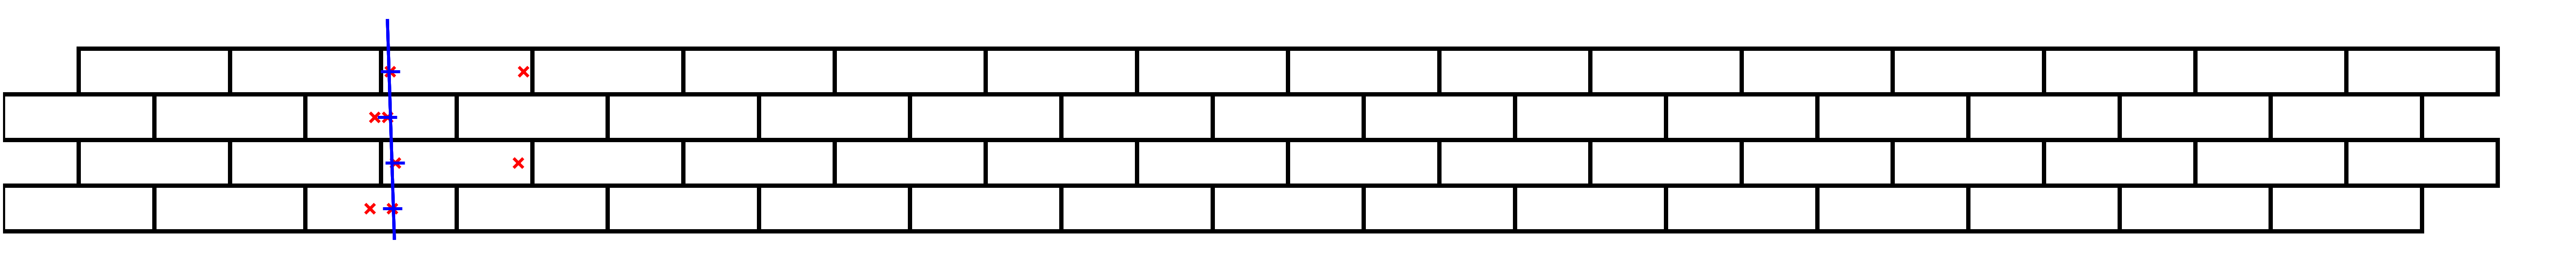

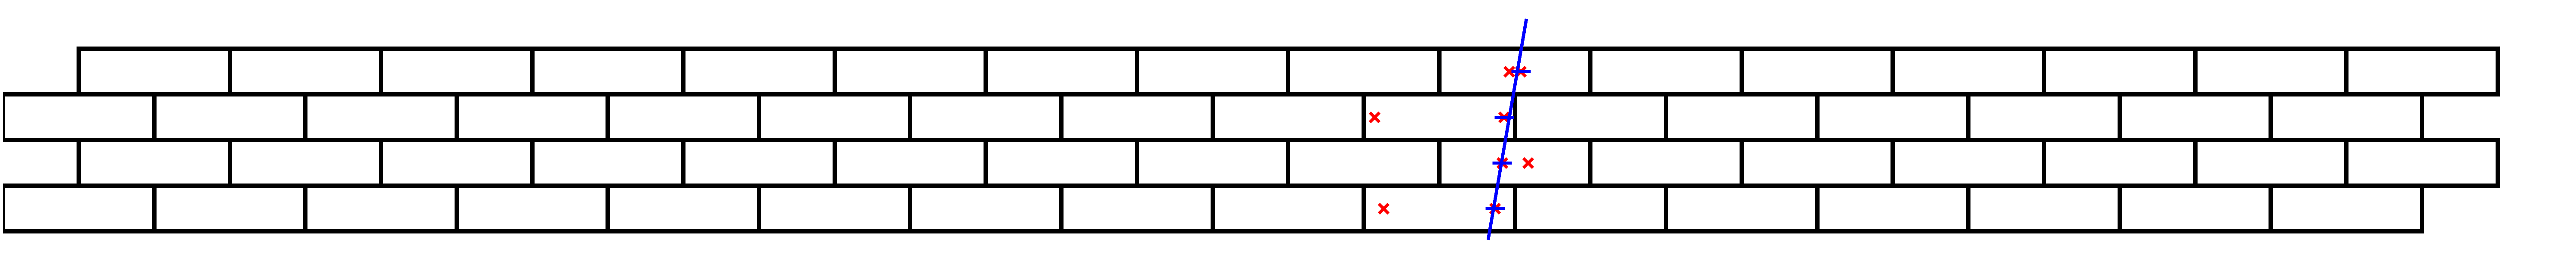

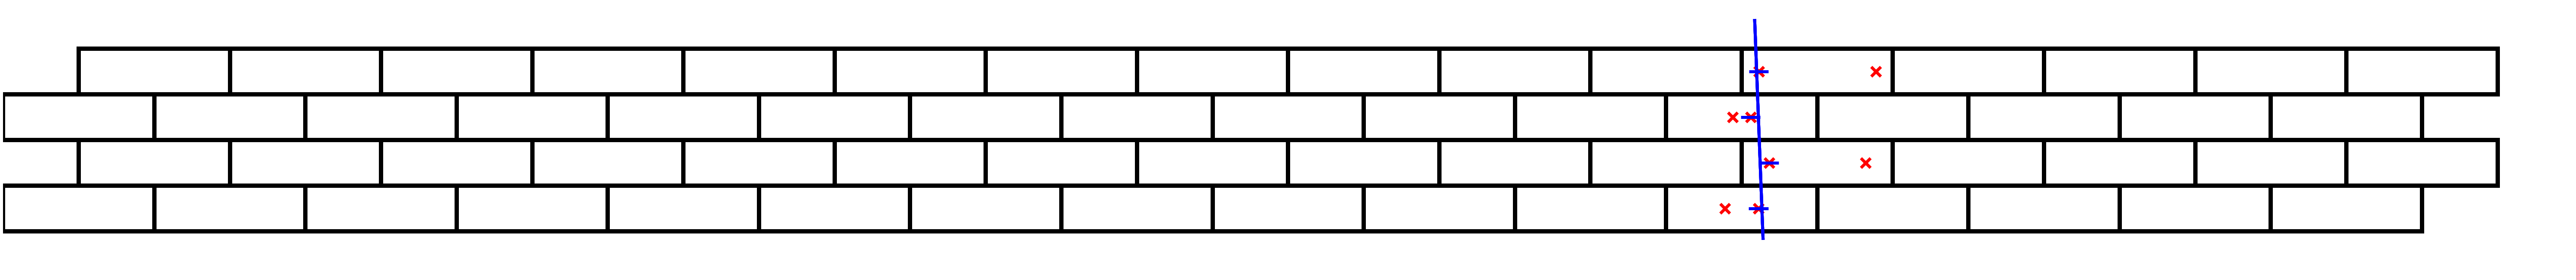

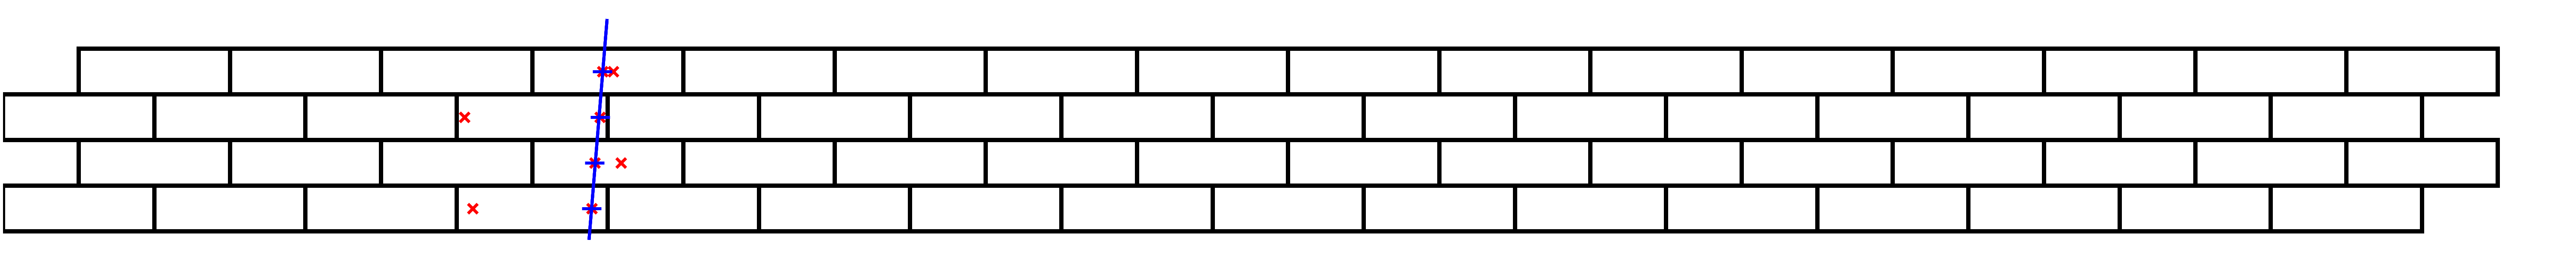

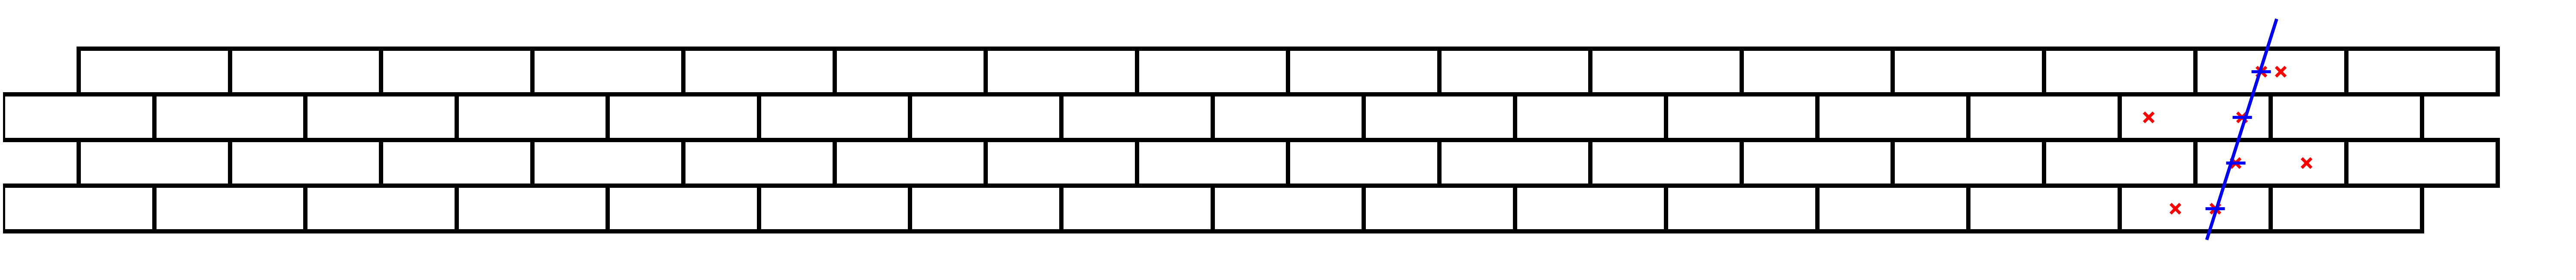

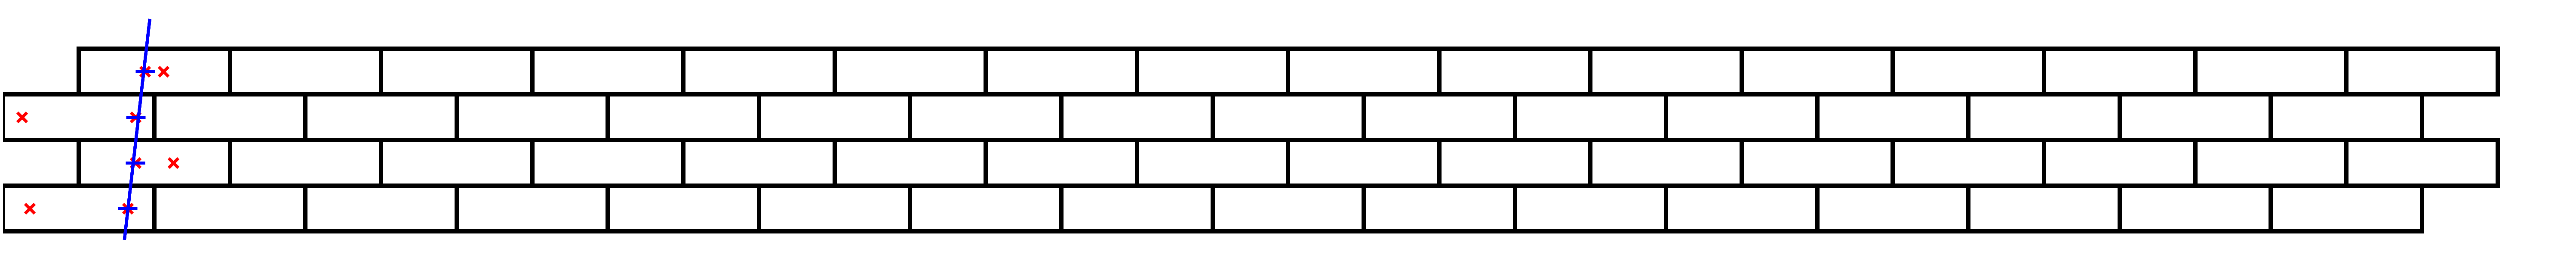

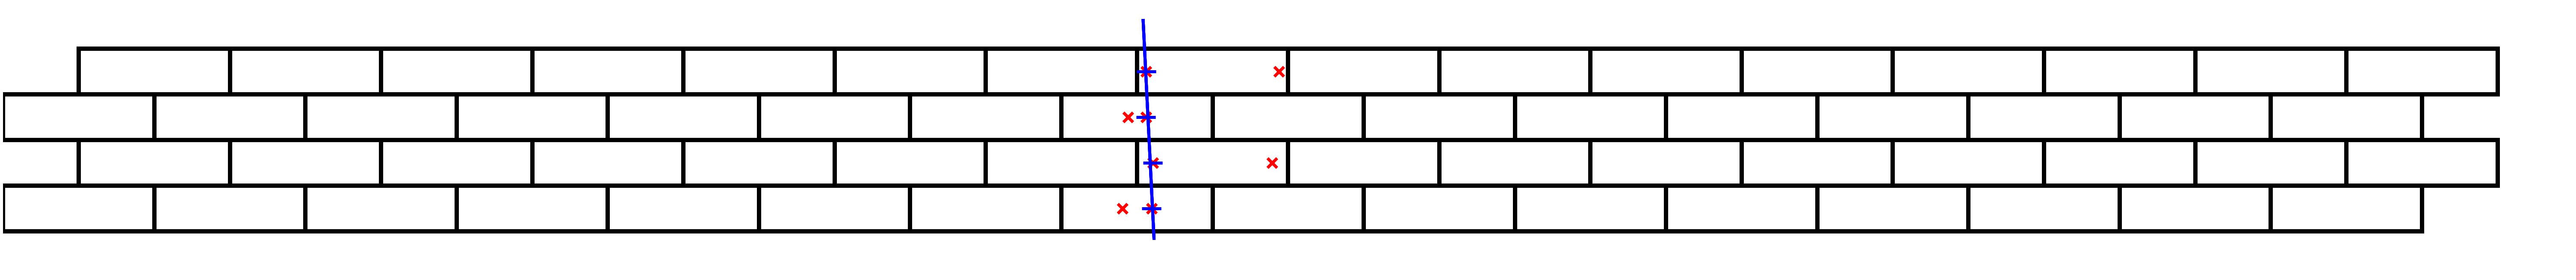

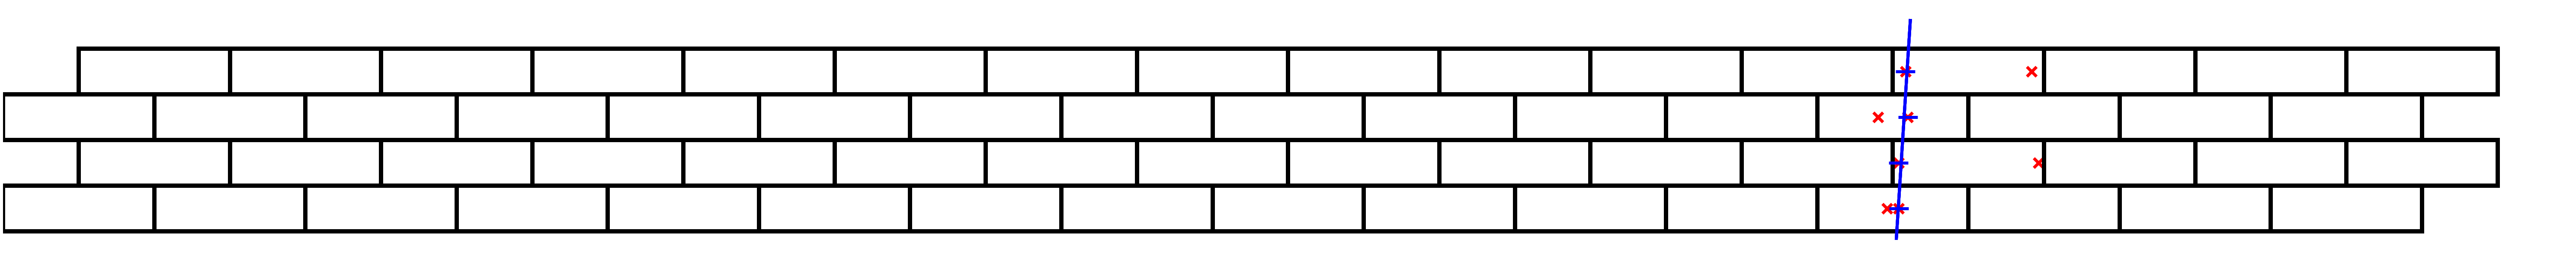

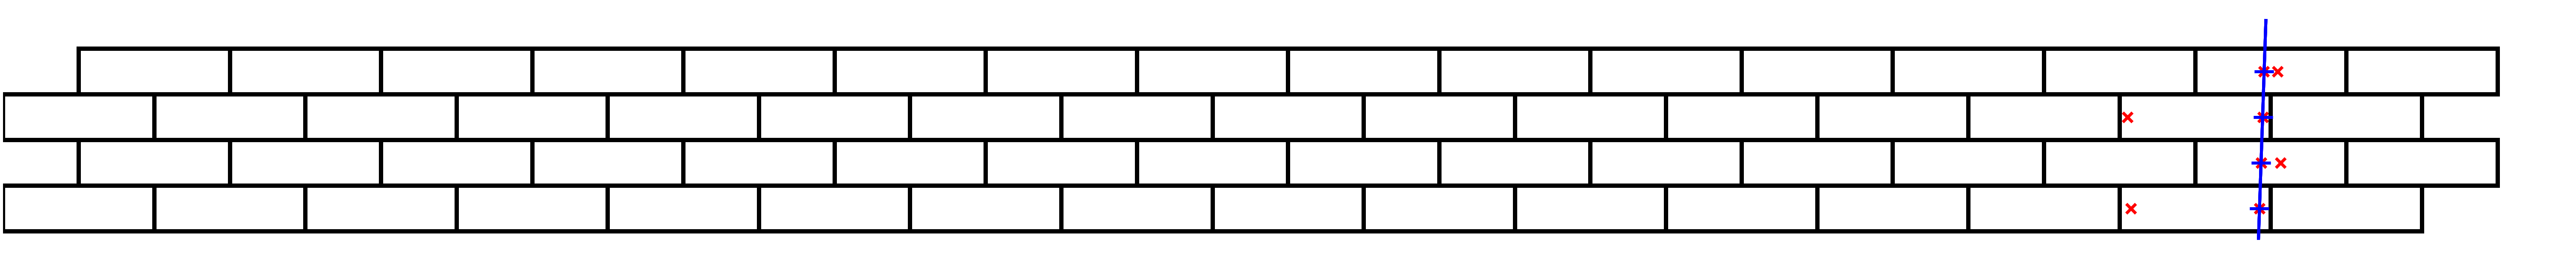

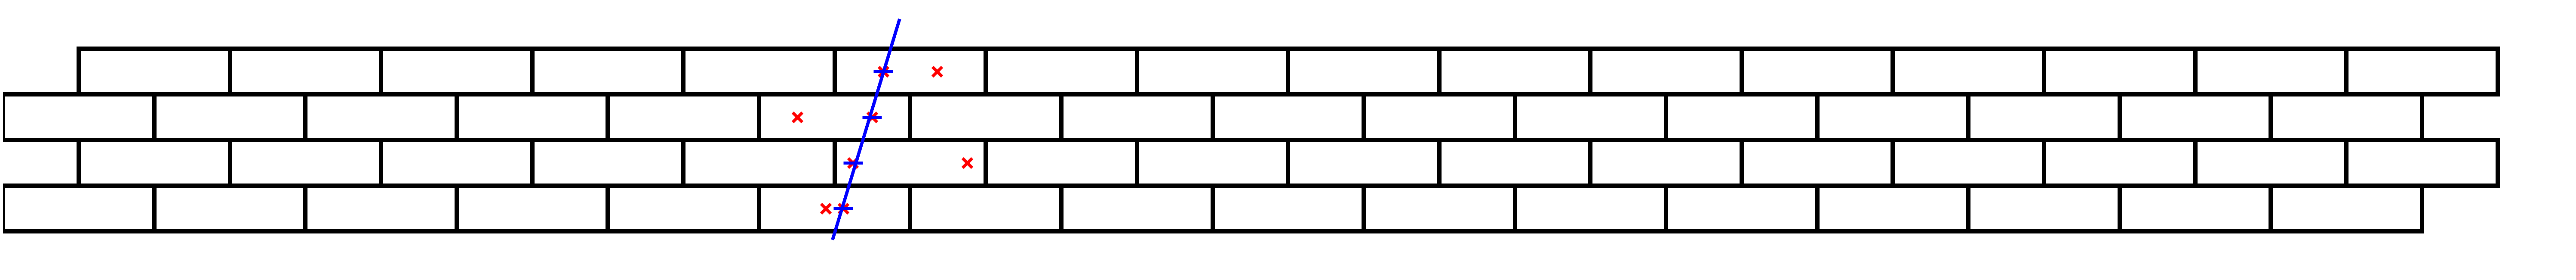

In [29]:
delta_x = 42/(2*390)*(50) #this is a constant

def event_and_line_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of one cell
    dx = 42
    dy = 13
    
    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    xr = event['XR'].to_numpy()
    xl = event['XL'].to_numpy()
    X = event['X_BEST'].to_numpy()
    Y = event['Y'].to_numpy()

    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 


    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(xr,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.scatter(xl,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.errorbar(X, Y, xerr=delta_x, fmt='.', c = 'blue', linewidth = 7) # errorbar
    ax1.plot([(-2-event.Q)/event.M,(60-event.Q)/event.M] ,[-2,60], c= 'blue', linewidth = 7)
    return ax1

#print("Plotting reconstructed trajectories HAVING CHECKED compatibility with experimental error")
for i in np.unique(df.index)[:10] :
    event_and_line_plot(df.loc[i])

In [30]:
stop = time.time()
print("total execution time (s):",stop-start,"i.e.",(stop-start)/60,"min")

total execution time (s): 263.23323702812195 i.e. 4.387220617135366 min


## Analysis of reconstructed trajectories parameters as functions of estimated $\Delta t$ + $\alpha$ distribution
There's no unique way to estimate the error $\Delta t$ to be used throughout the project. For example one can argue that since the experimental uncertainty over $t$ for any given hit is $25 \ \text{ns}$ (due to how the detector works) it's enough to use this value as an acceptable estimate of $\Delta t$ everywhere. We may also observe that since we're in fact only concerned with time *differences* we actually need to use $\Delta t = 50 \ \text{ns}$ due to the rules of error propagation, though, but even this estimate may not be enough to not throw away perfectly physical events! Indeed since we used the electronic trigger (i.e. `TDC_CHANNEL=139`) to estimate the time pedestals we have actually been "cheating" all along, and therefore to compensate for this we should use an even bigger $\Delta t$ - but it's not clear how to produce a non-abitrary estimate of $\Delta t$ that correctly/satisfyingly adresses this issue.  
What's interesting to note is that the value of $\Delta t$ we use (which as discussed above can be one of multiple possible choices) decides how strictly we decide which events to discard and which to keep; $\Delta t$ is indeed used in `identify_events` and `check_experimental_compatibility` at the very end. Using a large $\Delta t$, therefore, not only lets more events through (ignoring the other filters), but also affects the distribution of $m$ and $q$ values obtained. To quantitatively study this effect we can plot an histogram of the slopes/intercepts - which is interesting to do in and of itself.   
Note: in the following cell we use the formulae:
$$\alpha = \frac{180^{\circ}}{\pi}\cdot\left(\frac{\pi}{2}-\arctan m\right) \qquad (m\geq0)$$
$$\alpha = -\frac{180^{\circ}}{\pi}\cdot\left(\frac{\pi}{2}-|\arctan m|\right) \qquad (m\leq0)$$
which represents the angle in degrees between each line and the vertical; apart from the $180^{\circ}/\pi$ conversion factor we use the fact that $m = \tan \beta$ (where $\beta$ is the angle wrt the $x$ axis). In order to switch to the angle $\alpha$ measured wrt the $y$ axis we need to add/subtract $\pi/2$ to/from $|\beta|$ if the slope is positive/negative, respectively.  
A formula which covers both cases is:
$$\alpha = \text{sign}(m)\cdot \frac{180^{\circ}}{\pi}\cdot\left(\frac{\pi}{2}-|\arctan m|\right)$$

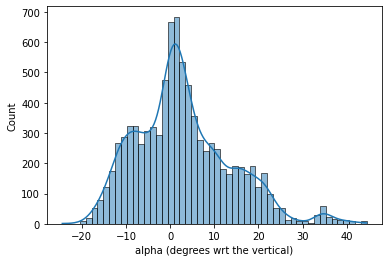

In [48]:
#alpha is the series of angles in degrees between each line and the vertical
alpha = (np.pi/2 - np.arctan(df.M).abs())*180/np.pi*np.sign(df.M)
alpha = alpha.rename("ALPHA")
#display(alpha)
#plt.hist(alpha);
sns.histplot(alpha,kde=True)
plt.xlabel("alpha (degrees wrt the vertical)");

We obtain the expected result: most trajectories are almost vertical, and those that are not are close to being vertical and have approximately the same probability of having a positive or negative slope for any fixed value of $\alpha$. The fact that the obtained distribution is approximately a gaussian makes sense, too: our reconstructed muon bean should be most intense in the center and less and less towards the outer ends.   
Furthermore we notice that every angle is between $\pm 45-50^{\circ}$ approximately; this is to be expected, since the detector is most sensitive in that range and therefore there can be no reconstructed trajectories with $\alpha\gg 50^{\circ}$, i.e. events of these kinds are expected to be filtered out by at least one of the filters implemented thus far (which may be a little biased towards lines of this kind, though).

In [32]:
#from the above histogram we notice most angles are between +-20 degrees
print("Percent fraction of angles between +20 and -20 degrees:",(alpha[alpha.abs() < 20]).shape[0]/len(alpha)*100,"%")

Percent fraction of angles between +20 and -20 degrees: 92.4215044047888 %


We can easily compare this with what `alpha` becomes equal to if we switch to an estimated time uncertainty corresponding to $50 \ \text{ns}$.

Percent fraction of angles between +20 and -20 degrees: 92.38664561245207 %


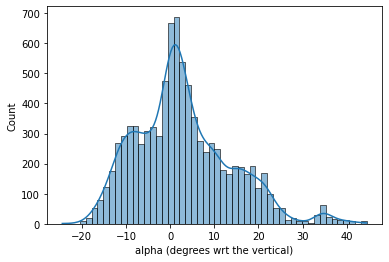

In [49]:
alpha_440 = pd.read_csv("alpha_440.csv").set_index(["ORBIT_CNT","EVENT"]).squeeze().rename("ALPHA") #the .squeeze() method converts a dataframe to a series
#plt.hist(alpha_440);
sns.histplot(alpha_440,kde=True)
plt.xlabel("alpha (degrees wrt the vertical)");
print("Percent fraction of angles between +20 and -20 degrees:",(alpha_440[alpha_440.abs() < 20]).shape[0]/len(alpha_440)*100,"%")

We notice that doubling $\delta t$ almost had no effect on the reconstructed trajectories, so at least in this range of values it doesn't seem to matter much.

## Choosing an optimal $\Delta t$: "model selection & validation"
Let's say we have a list of possible estimates of $\Delta t$. Can we choose the "best" one?  
Of course any such procedure to pick the best estimate is arbitrary to some extent since $\Delta t$ itself is somewhat "controversial", but we can propose the following ML-inspired approach (which is both simple and satisfying, at least in principle). We already noted that the value of $\Delta t$ may modify the distribution of $\alpha$'s associated to accepted events; in order to pick one we may therefore decide to use the $\Delta t$ that gives the best fit possible on average (i.e. the best average linear correlation coefficient $r$, for example). While this may "overfit" our data it may still be an approach worth pursuing, but since this would require an even better performing code than this we just leave these suggestions here.

# Further optimizations strategies: Parallelization with `dask.dataframe`
While mentioning `multiprocessing` we already explained why parallelization can speed up our code when dealing with large datasets; in particular in all the most demanding cells we process different events sequentially even though them being independent implies we could process them *in parallel*, which lets us use multiple cores and deal with datasets that wouldn't fit into memory. We can sistematically parallelize everything by using a *dask dataframe* instead of a pandas one. Dask adopts a lazy approach: everytime we perform some operations on our dataframe those aren't actually executed, and instead the compiler saves a graph (i.e. a special list) of operations that it would need to perform in order to actually compute the "final" dataframe. If we stack all these virtual (more appropriately: *delayed*) operations and at the very end call the `.compute()` method then dask will be able to use the graph it built so far (which we can visualize using `.visualize()`) to organize code execution in a parallelized way; apart from this dask dataframes work similarly to pandas dataframes.   
Unfortunately due to lack of experience, time and extensive online documentation (`dask` is a relatively young project, it seems) I wasn't able to make this work; nonetheless I still include a working proof of concept that is able to show the differences between pandas and dask.dataframe.

In [35]:
import dask.dataframe as dd

dataset = dd.read_csv("data_000000.txt",assume_missing=True) #without that parameter type inference fails: it tries to cast bx & meas to int64, but float64 is needed to the presence of some nan

dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30

fpga = dataset['FPGA'] == 1 
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] < 129) 
trigger = dataset['TDC_CHANNEL'] == 139 

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel] 

dataset["DETECTOR"] = -1 #.loc[] can't be used due to dask.dataframe deficiencies wrt pandas, but without it it's impossible to create a column on the fly; therefore I assign it here

for i in range(len(detectors)) : 
    #dataset.loc[detectors[i],'DETECTOR'] = i+1 #https://stackoverflow.com/questions/54360549/dask-item-assignment-cannot-use-loc-for-item-assignment
    #dataset['DETECTOR'].mask(detectors[i],i+1) #mask does NOT support inplace=True!
    dataset["DETECTOR"] = dataset['DETECTOR'].mask(detectors[i],i+1) #with dask.dataframe one needs to replace .loc[] with .mask() anytime a logical query is to be performed

dataset['DETECTOR'] = dataset['DETECTOR'].mask(trigger,0) 

rest = dataset['TDC_CHANNEL'] % 4 
dic_replace = {0:1, 2:2, 3:3, 1:4}
dataset['LAYER'] = rest
# dataset['LAYER'].replace(dic_replace, inplace=True)
dataset["LAYER"] = dataset['LAYER'].replace(dic_replace)
dataset['LAYER'].mask(trigger,0) 
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

#we flag unused triggers for removal, i.e. we assign NaN to hits with TDC_CHANNEL equal to 129,130,...,138
for i in range(129,139) :
    dataset.mask(dataset["TDC_CHANNEL"] == i, np.nan) #.dropna() will remove these
    #once again .loc[] needs to be replaced with .mask()

dataset = dataset.dropna()

#remove orbits with no trigger activations
dfd = dataset
dfd = dfd.set_index("ORBIT_CNT") 
dfd = dfd.loc[dfd[dfd.TDC_CHANNEL == 139].index]
dfd = dfd.drop(["BX_COUNTER","TDC_MEAS"],axis=1)


# dfd = dfd.repartition(npartitions=len(dfd.compute().groupby("ORBIT_CNT").nunique()))
# print(dfd.known_divisions)
# print(dfd.npartitions)

#df.loc[(df.groupby(["ORBIT_CNT"],group_keys=False).size() > 2)] #this indexing fails even with an apparently sound repartition even though [...] works, I'm not sure why
# ValueError: Not all divisions are known, can't align partitions. Please use `set_index` to set the index.

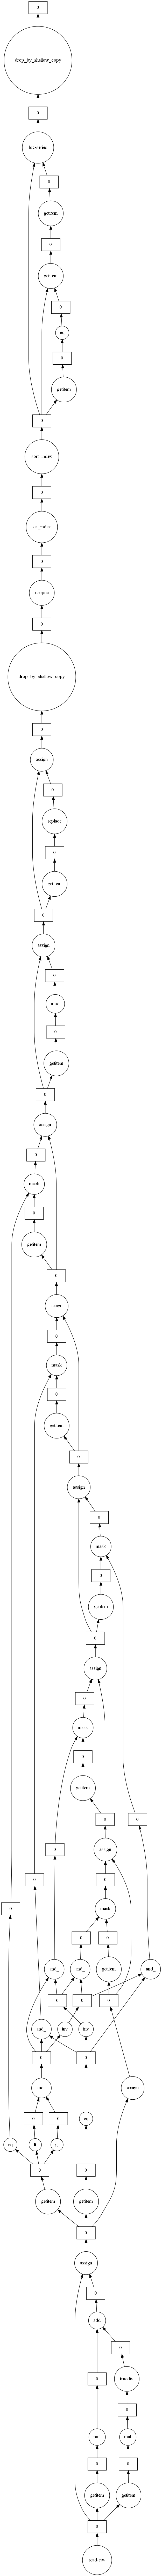

In [36]:
dfd.visualize() #to be able to run this graphviz needs to be installed and added to PATH; its accompanying pip package needs to be installed as well

In [37]:
dfd.compute()

,TDC_CHANNEL,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,
1.897415e+09,29.0,50657.500000,1,4.0
1.897415e+09,27.0,50609.166667,1,3.0
1.897415e+09,139.0,50700.000000,0,3.0
1.897415e+09,33.0,50661.666667,1,4.0
1.897415e+09,26.0,50366.666667,1,2.0
...,...,...,...,...
1.920940e+09,37.0,62829.166667,3,4.0
1.920940e+09,38.0,62808.333333,3,2.0
1.920940e+09,102.0,62768.333333,4,2.0


# A final remark on the optimization task + further optimization strategies
What we achieved is this notebook is a pretty substantial improvement in performance; but while it's true that this notebook works faster (and hence better) than the previous implementation it's also true that in principle we can do *much better*. It's obvious that if we're only concerned with the analysis of a single csv then waiting  just ~4 minutes for our code to complete execution is quite good, but becomes too much if for example we desire to analyze our entire dataset; that's why it may be of interest to push the boundaries of optimization even further.  
We already explained why using `dask.dataframe` can not only greatly improve performance but also efficiently let us work with dataset much bigger than what would fit in memory (this is more sophisticated than simply looping over each file and keeping the small fraction of good events); this approach can be improved even more this way.   
As long as we stick to basic 1d `numpy` broadcasting/vectorization it's trivial to jit code with `numba`; where this cannot be done it's always possible to rewrite code in a loopy, C-friendly style in place of fully vectorized numpy operations. We may therefore carefully separate `numpy` from `pandas`/`dask.dataframe`, jit/jit and "loop-ize" every numpy vectorized operation and use the likes of `dask.dataframe.DataFrame.apply()` with this numba sub-functions. Where simple numerical evaluation is concerned we may turn to even more advanced libraries like `numexpr`; combining all these strategies would make the task of analyzing 50+ gb of data in a reasonable enough time definetively feasible - and the execution time may be further reduced with even more advanced approaches (for example using `numba`'s CUDA implementation, i.e. using a GPU to further speed up parallelized code execution).      



Many online articles document that even just `dask`+`numba`  guarantees an almost magical result (see for example [this](https://towardsdatascience.com/how-i-learned-to-love-parallelized-applies-with-python-pandas-dask-and-numba-f06b0b367138)); why, therefore, were all these amazing tips not applied in this notebook?     
*Answer:* because of the philosophy explained at the very beginning of this file. Even though libraries like `numba` and `dask` are extremely user-friendly (especially if we compare their ease of use with the performance improvements they let an advanced user accomplish) implementing all these strategies and implementing them *well* is a *highly non-trivial task*, and we can't really afford to spend the time which would be needed to rewrite everything in this much more complex way. I conclude this brief remark on the optimization task by observing that analyzing our dataset as a whole was never really part of the assignment for this exam; therefore I reckon there are solid reasons to believe the compromise we reached to be good enough. Therefore even though it's true that the performance gains guaranteed by vanilla `numpy` vectorization pale in comparison with what can be achieved with the likes of `dask`+`numba` we also have to acknowledge that *optimization is a never-ending task*, and that at some point the strive for better and better performance is simply not worth it (especially if the result is good enough and if substantially improving it would require starting from scratch and likely spend much more time implementing fantastically complicated approaches).